# EDA
**Data Source:** 
- Anomanlies_tracker.csv
- RDS database (connection credentials in .env file) that contains the financial reports in relational format

**Goal:** 
In this phase of the project, we will focus on ingesting the data, performing initial exploration, handling missing values, describing basic statistics, and conducting exploratory data analysis on the dataset generated during the preceding steps. This analysis aims to provide insights into the distribution of our variables, evaluate the balance among our classes, identify any necessary additional transformations for subsequent modeling stages, and ensure the suitability of both dependent and independent variables for our classification task.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
import os

import sys
sys.path.append("/Users/zemariatrindade/BTS/Financy_App/Scripts_and_Data/venv/lib/python3.11/site-packages")
import psycopg2

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

#### Importing env variables

In [2]:
# Load environment variables from .env file
load_dotenv()

dbname = os.getenv('db_name')
user = os.getenv('db_username')
password = os.getenv('db_password')
host = os.getenv('db_host')
port = os.getenv('db_port')

## Data Ingestion

### Data source 1: Importing anomaly cases
found with research to annotate our dataset

In [3]:
anomalies_df = pd.read_csv("Anomalies_tracker.csv")
anomalies_df['cik_str'] = anomalies_df['cik_str'].astype(str).str.zfill(10)

In [4]:
anomalies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   cik_str                        227 non-null    object
 1   Scandal Year                   227 non-null    int64 
 2   Ticker                         227 non-null    object
 3   Company Name                   227 non-null    object
 4   Anomaly Ticker                 227 non-null    object
 5   earliest XBRL                  227 non-null    int64 
 6   XBRL available during anomaly  227 non-null    object
 7   10-Q/ 10-K available           227 non-null    object
 8   Decision                       227 non-null    object
 9   Detail - needs to be updated   227 non-null    object
dtypes: int64(2), object(8)
memory usage: 17.9+ KB


In [5]:
anomalies_df.head()

,cik_str,Scandal Year,Ticker,Company Name,Anomaly Ticker,earliest XBRL,XBRL available during anomaly,10-Q/ 10-K available,Decision,Detail - needs to be updated
0,0000002488,2009,AMD,ADVANCED MICRO DEVICES INC,AMD,2007,Yes,Yes,Yes,AMD (Antitrust lawsuit)
1,0000005272,2000,AIG,"AMERICAN INTERNATIONAL GROUP, INC.",AIG,2006,No,Yes,No,Accounting Fraud (Financial Misrepresentaion)
2,0000005272,2001,AIG,"AMERICAN INTERNATIONAL GROUP, INC.",AIG,2006,No,Yes,No,Accounting Fraud (Financial Misrepresentaion)
3,0000005272,2005,AIG,"AMERICAN INTERNATIONAL GROUP, INC.",AIG,2006,No,Yes,No,Accounting Fraud (Financial Misrepresentaion)
4,0000005272,2000,AIG-PA,"AMERICAN INTERNATIONAL GROUP, INC.",AIG,2006,No,Yes,No,Accounting Fraud (Financial Misrepresentaion)


##### Making sure we don't have the same anomaly repeated
In the Anomalies_tracker, we had different tickers for the same cik number

In [6]:
anomalies_df = anomalies_df.drop_duplicates(subset=["cik_str","Scandal Year"])

##### filtering for the years and forms format where we have data to match

In [7]:
anomaly_cases = anomalies_df[(anomalies_df["Decision"]=="Yes")][["cik_str","Scandal Year","Anomaly Ticker"]]

In [8]:
print("Number of cases:", len(anomaly_cases))
print("Number of tickers:", len(anomaly_cases["Anomaly Ticker"].unique()))

anomaly_cases

Number of cases: 53
Number of tickers: 40


,cik_str,Scandal Year,Anomaly Ticker
0,0000002488,2009,AMD
16,0000019617,2006,JPM
17,0000019617,2007,JPM
18,0000019617,2008,JPM
19,0000019617,2009,JPM
20,0000019617,2010,JPM
21,0000019617,2012,JPM
28,0000027419,2008,TGT
29,0000040545,2009,GE
30,0000047217,2012,HPQ


We have a total of 53 anomaly cases. We assume the company was anomalous the entire year. Given that we have more than 1 type of report per year, we will end up with more total anomalous entries.

These 53 anomaly cases represent 40 companies

### Data source 2: Querying the aws RDS database
for the tickers we have found at least 1 anomaly record

In [9]:
tuple_tickers = tuple(anomaly_cases["Anomaly Ticker"].unique())

In [10]:
# Import the data
conn = psycopg2.connect(dbname=dbname,
                        user=user,
                        password=password,
                        host=host,
                        port=port)
cursor = conn.cursor()

query = f"""
    SELECT * 
    FROM edgar_selected_tickers_table
    WHERE ticker in {tuple_tickers};
"""
cursor.execute(query)
results = cursor.fetchall()

cursor.close()
conn.close()

In [11]:
column_names = ['end_date', 'ticker', 'reporting_frame', 'form', 'account', 'unit', 'value']
query_df = pd.DataFrame(results, columns=column_names)

In [13]:
query_df["year"] = query_df["end_date"].apply(lambda x: int(x.strftime("%Y")))
query_df = query_df.iloc[:,[0,7,1,2,3,4,5,6]]

In [14]:
query_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943986 entries, 0 to 943985
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   end_date         943986 non-null  object 
 1   year             943986 non-null  int64  
 2   ticker           943986 non-null  object 
 3   reporting_frame  943986 non-null  object 
 4   form             943986 non-null  object 
 5   account          943986 non-null  object 
 6   unit             943986 non-null  object 
 7   value            943986 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 57.6+ MB


In [15]:
query_df.head()

,end_date,year,ticker,reporting_frame,form,account,unit,value
0,2019-03-31,2019,WFC,us-gaap,10-Q,AllowanceForLoanAndLeaseLossesWriteOffs,USD,1.063000e+09
1,2009-01-31,2009,WFC,dei,10-K,EntityCommonStockSharesOutstanding,shares,4.237777e+09
2,2009-07-31,2009,WFC,dei,10-Q,EntityCommonStockSharesOutstanding,shares,4.671609e+09
3,2009-10-30,2009,WFC,dei,10-Q,EntityCommonStockSharesOutstanding,shares,4.685064e+09
4,2010-04-30,2010,WFC,dei,10-Q,EntityCommonStockSharesOutstanding,shares,5.210152e+09


### Handling duplicated records
In this section we will be dropping any duplicated rows (if any). This is a crucial part for assuring data quality.
It is likely that we find a lot of duplicate records because each report has data from the present period and previous analogous period.

In [78]:
# Count the number of duplicate records
num_duplicates = query_df.duplicated().sum()

# Drop all duplicate records
query_df = query_df.drop_duplicates()

print(f"Number of duplicate records dropped: {num_duplicates}")

Number of duplicate records dropped: 358358


### Handling missing values
It is likely that we dont find any null value. However, when we run a pivot table on top of this dataframe, we need to re-do this exercise

In [177]:
# Number of missing values
missing_values = query_df.isnull().sum()
print("Missing Values per Column:\n")
print(missing_values)

Missing Values per Column:

end_date           0
year               0
ticker             0
reporting_frame    0
form               0
account            0
unit               0
value              0
dtype: int64


### Unique values in categorical features

In [98]:
# Select categorical columns
categorical_cols = query_df.select_dtypes(include=['object', 'category']).columns

# Get unique values for each categorical column
unique_values = {col: query_df[col].unique() for col in categorical_cols}

# Print unique values in a readable format
for col, values in unique_values.items():
    print(f"Number of unique values in Column '{col}':\n {len(values)}")
    print(f"Column '{col}':\n {values}\n\n")

Number of unique values in Column 'end_date':
 2229
Column 'end_date':
 [datetime.date(2019, 3, 31) datetime.date(2009, 1, 31)
 datetime.date(2009, 7, 31) ... datetime.date(2017, 9, 7)
 datetime.date(2019, 7, 12) datetime.date(2023, 9, 4)]


Number of unique values in Column 'ticker':
 40
Column 'ticker':
 ['WFC' 'C' 'JPM' 'HPQ' 'GRPN' 'GM' 'TGT' 'HD' 'LVS' 'AAPL' 'BAC' 'TSLA'
 'AMZN' 'GE' 'INTC' 'GOOG' 'PEP' 'SBUX' 'AMD' 'NFLX' 'CSCO' 'ORCL' 'EBAY'
 'MDLZ' 'QCOM' 'SQ' 'PYPL' 'TSN' 'LYFT' 'SJM' 'KHC' 'L' 'YUM' 'DPZ' 'PZZA'
 'EAT' 'CAKE' 'BJRI' 'RRGB' 'PLAY']


Number of unique values in Column 'reporting_frame':
 4
Column 'reporting_frame':
 ['us-gaap' 'dei' 'invest' 'srt']


Number of unique values in Column 'form':
 6
Column 'form':
 ['10-Q' '10-K' '10-Q/A' '8-K' '10-K/A' '8-K/A']


Number of unique values in Column 'account':
 4422
Column 'account':
 ['AllowanceForLoanAndLeaseLossesWriteOffs'
 'EntityCommonStockSharesOutstanding' 'EntityPublicFloat' ...
 'SaleLeasebackTransactionImp

### Running a pivot on top of our dataframe
So we can have our financial accounts as columns

In [123]:
pivoted_df = query_df.pivot_table(index=['end_date','year', 'ticker', 'form'],#,reporting_frame', 'form'],#, 'unit'], 
                            columns='account',
                            values='value',
                            aggfunc='sum')#,
                            #fill_value=0)
# Fill any NaN values that might be created in the process.\We have to justify why 0 is a valid value.
pivoted_df = pivoted_df.reset_index()

In [124]:
pivoted_df

account,end_date,year,ticker,form,AcceleratedShareRepurchaseProgramAdjustment,AcceleratedShareRepurchasesFinalPricePaidPerShare,AcceleratedShareRepurchasesSettlementPaymentOrReceipt,AccountsAndNotesReceivableNet,AccountsAndOtherReceivablesNetCurrent,AccountsNotesAndLoansReceivableNetCurrent,...,WeightedAverageNumberDilutedSharesOutstandingAdjustment,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfShareOutstandingBasicAndDiluted,WeightedAverageNumberOfSharesContingentlyIssuable,WeightedAverageNumberOfSharesIssuedBasic,WeightedAverageNumberOfSharesOutstandingBasic,WeightedAverageNumberOfSharesRestrictedStock,WithdrawalFromContractHoldersFunds,WorkersCompensationLiabilityCurrent,WriteOffOfDeferredDebtIssuanceCost
0,1991-10-01,1991,BJRI,10-K,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-12-27,1998,AMD,10-K,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-10-01,1999,BJRI,10-K,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001-02-02,2001,PLAY,10-K,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-12-31,2005,MDLZ,8-K,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7757,2024-05-16,2024,CSCO,10-Q,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7758,2024-05-24,2024,EBAY,10-K/A,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7759,2024-05-24,2024,RRGB,10-Q,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7760,2024-05-24,2024,TGT,10-Q,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Univariate Analysis with our Categorical Features

#### 1. Year

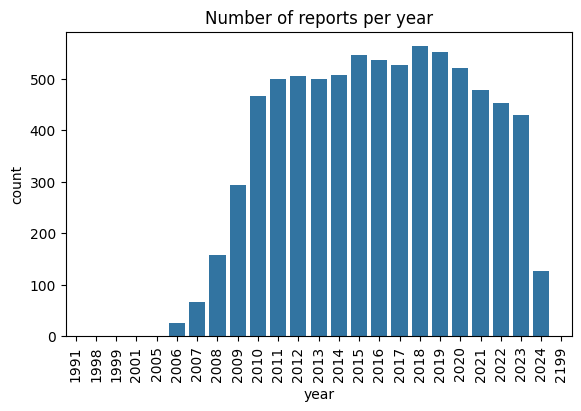

In [219]:
# Plotting the number of reports per type of form
plt.figure(figsize=(6,4))
ax = sns.countplot(x="year", data=pivoted_df, legend=False)

plt.title("Number of reports per year")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

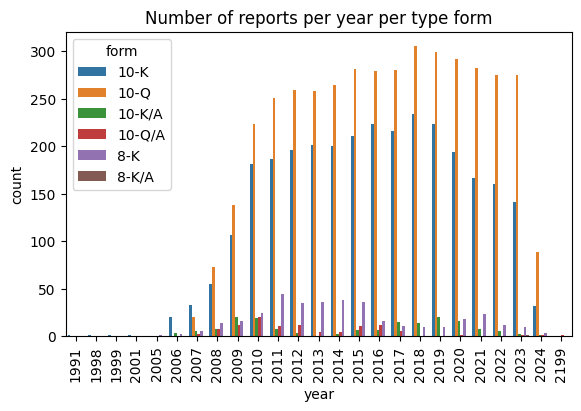

In [228]:
# Plotting the number of reports per type of form
plt.figure(figsize=(6,4))

form_order = ['10-K', '10-Q', '10-K/A', '10-Q/A', '8-K', '8-K/A']
ax = sns.countplot(x="year", data=pivoted_df ,hue="form", hue_order = form_order)

plt.title("Number of reports per year per type form")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

We can conclude that the majority of reports submitted per year are of type "10-Q". Let's remove from our analysis any entry poins before 2008 and after 2024 because they don't represent the distribution of the data, and/or they have very little entry points that could represent noise.
**Scope of our analysis from now on: 2008-2024**

In [202]:
staged_df_1 = pivoted_df[(pivoted_df["year"]>=2008) & (pivoted_df["year"]<=2024)]

In [203]:
entries_removed = pivoted_df.shape[0] - staged_df_1.shape[0]
print(f"We removed {entries_removed} entries")
print(f"Total number of entries now: {staged_df_1.shape[0]}")

We removed 98 entries
Total number of entries now: 7664


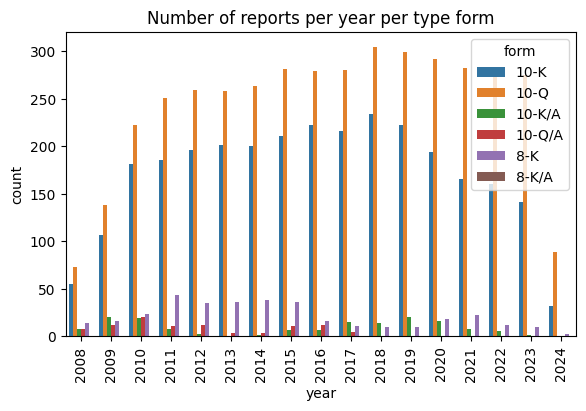

In [223]:
# Plotting the number of reports per type of form
plt.figure(figsize=(6,4))

form_order = ['10-K', '10-Q', '10-K/A', '10-Q/A', '8-K', '8-K/A']
ax = sns.countplot(x="year", data=staged_df_1 ,hue="form", hue_order = form_order)

plt.title("Number of reports per year per type form")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

Conclusions:
1. The number of reports submitted for our selected companies grew up until 2018, and then started to slowing decreasing.
2. In the time-spam of this analysis, 10-Q reports were the always the top type form submitted followed by 10-K

#### 2. Ticker

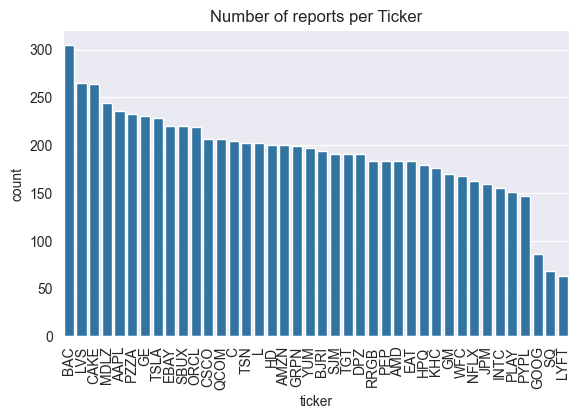

In [318]:
# Plotting the number of reports per type of form
plt.figure(figsize=(6,4))
ax = sns.countplot(x="ticker", data=staged_df_1, dodge=False, legend=False, order=staged_df_1['ticker'].value_counts().index)

plt.title("Number of reports per Ticker")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [319]:
# WEIRD INFO: GOOGLE START TO BE TRADED IN 2004....Why do we have only date from 2012?
staged_df_1[staged_df_1["ticker"]=="GOOG"].year.unique()

array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023, 2024])

#### 3. Form

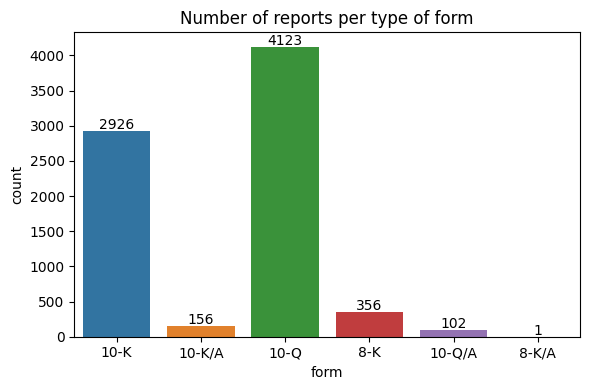

In [206]:
# Plotting the number of reports per type of form
plt.figure(figsize=(6,4))
ax = sns.countplot(x="form", data=staged_df_1, hue="form",dodge=False, legend=False)

# Add count values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 4), 
                textcoords = 'offset points')

plt.title("Number of reports per type of form")
plt.tight_layout()
plt.show()

#### 4. Financial Accounts
Let's handle missing data and quantify to make a decision

Let's do the same exercise but now segmenting by type form to see if we get different results

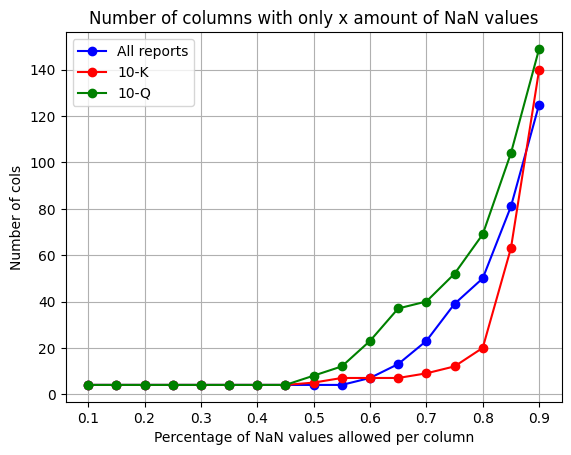

In [281]:
nr_cols_all = []
nr_cols_10_k = []
nr_cols_10_q = []

for i in np.arange(0.1,0.95,0.05):
    threshold = i.round(2)

    mask_all = (staged_df_1.isna().sum()/len(staged_df_1) <= threshold).to_list()
    nr_cols_all.append(len([staged_df_1.columns.to_list()[ind] for ind, col in enumerate(mask_all) if col==True]))
    
    mask_10_k = (ten_k_df.isna().sum()/len(ten_k_df) <= threshold).to_list()
    nr_cols_10_k.append(len([ten_k_df.columns.to_list()[ind] for ind, col in enumerate(mask_10_k) if col==True]))
    
    mask_10_q = (ten_q_df.isna().sum()/len(ten_q_df) <= threshold).to_list()
    nr_cols_10_q.append(len([ten_q_df.columns.to_list()[ind] for ind, col in enumerate(mask_10_q) if col==True]))
    
plt.title("Number of columns with only x amount of NaN values")
plt.xlabel("Percentage of NaN values allowed per column")
plt.ylabel("Number of cols")

plt.plot(np.arange(0.1, 0.95, 0.05), nr_cols_all, color="blue", label="All reports", marker='o')
plt.plot(np.arange(0.1, 0.95, 0.05), nr_cols_10_k, color="red", label="10-K", marker='o')
plt.plot(np.arange(0.1, 0.95, 0.05), nr_cols_10_q, color="green", label="10-Q", marker='o')

plt.legend()
plt.grid()
plt.show()

**Conclusions:**
- There is no financial account that is present in all reports of out dataset.
- As a second ideal scenario, we would be dealing with only columns with less than 10% of NaN values. However, the only columns that satisfy that requirement are the index columns. In fact, we only start seeing the financial account showing up at 50% of NaN values.
- The 10-Q report type contains less NaN values per column compared to 10-K and all reports all together.

**Next steps**
- Is there a ticker that reports in a very different way and therefore being responsable for this many NaN values?
- What if we would only use 10-Q reports and only financial accounts present in at least 40% of the reports of out dataset ??? If yes, how are these financial accounts distributed?

**Comments:**
#TO DO

**Do all tickers report their accounts in the same way?**

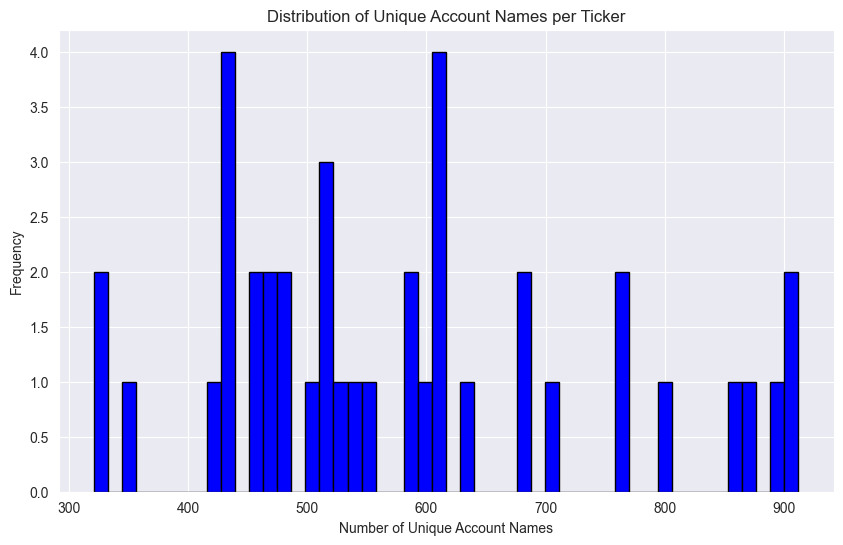

ticker
BJRI    321
LYFT    321
CAKE    347
PLAY    424
RRGB    430
DPZ     436
PYPL    437
HD      438
NFLX    454
LVS     458
SQ      463
GOOG    465
SJM     479
ORCL    484
AAPL    500
TGT     513
TSN     513
AMZN    515
EAT     526
PZZA    538
SBUX    546
PEP     584
YUM     584
GM      593
TSLA    609
EBAY    610
KHC     616
INTC    616
MDLZ    629
HPQ     676
QCOM    681
AMD     704
C       761
CSCO    762
L       797
GRPN    856
BAC     866
JPM     890
WFC     903
GE      912
dtype: int64


In [347]:
account_columns = staged_df_1.columns[4:-1]
unique_accounts_per_ticker = staged_df_1.groupby('ticker')[account_columns].apply(lambda x: x.notna().any().sum()).sort_values()

# Visualize the distribution of unique account names per ticker
plt.figure(figsize=(10, 6))
plt.hist(unique_accounts_per_ticker, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Unique Account Names per Ticker')
plt.xlabel('Number of Unique Account Names')
plt.ylabel('Frequency')
plt.show()

# Print the unique accounts per ticker for further inspection
print(unique_accounts_per_ticker)

No. The unique account names used by each ticker across time ranges from 321 and 912.

**Let's investigate if we can CLUSTER the tickers by the account names used.**

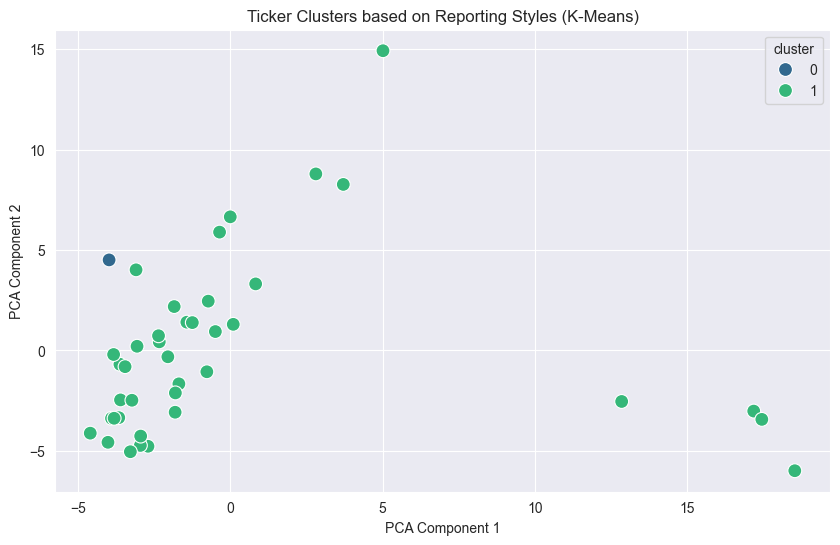

In [361]:
# Clustering

# K-MEANS
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

binary_matrix = staged_df_1.groupby('ticker')[account_columns].apply(lambda df: df.notna().any()).astype(int)

# Perform clustering
n_clusters = 2  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(binary_matrix)

# Add the cluster labels to the binary matrix for visualization
binary_matrix['cluster'] = clusters

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(binary_matrix.drop('cluster', axis=1))

# Create a DataFrame for visualization
visual_df = pd.DataFrame(pca_result, columns=['pca1', 'pca2'])
visual_df['cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visual_df, x='pca1', y='pca2', hue='cluster', palette='viridis', s=100)
plt.title('Ticker Clusters based on Reporting Styles (K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [357]:
# Evaluating the cluster definition
# Try different numbers of clusters
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(binary_matrix.drop('cluster', axis=1))
    silhouette_avg = silhouette_score(binary_matrix.drop('cluster', axis=1), clusters)
    print(f'Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.2f}')

Number of clusters: 2, Silhouette Score: 0.10
Number of clusters: 3, Silhouette Score: -0.01
Number of clusters: 4, Silhouette Score: -0.03
Number of clusters: 5, Silhouette Score: -0.01
Number of clusters: 6, Silhouette Score: -0.01
Number of clusters: 7, Silhouette Score: -0.00
Number of clusters: 8, Silhouette Score: 0.00
Number of clusters: 9, Silhouette Score: 0.00


DBSCAN resulted in a single cluster.


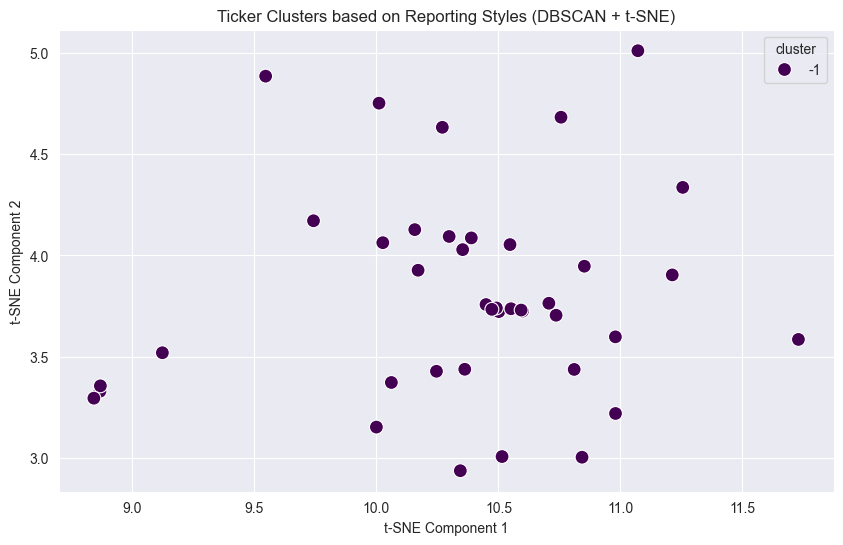

In [360]:
# DBSCAN

from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(binary_matrix)

# Calculate silhouette score for DBSCAN
if len(set(dbscan_clusters)) > 1:  # Silhouette score requires more than one cluster
    silhouette_avg = silhouette_score(binary_matrix, dbscan_clusters)
    print(f'DBSCAN Silhouette Score: {silhouette_avg:.2f}')
else:
    print('DBSCAN resulted in a single cluster.')

# Visualize with t-SNE
tsne_result = tsne.fit_transform(binary_matrix)
tsne_df = pd.DataFrame(tsne_result, columns=['tsne1', 'tsne2'])
tsne_df['cluster'] = dbscan_clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='cluster', palette='viridis', s=100)
plt.title('Ticker Clusters based on Reporting Styles (DBSCAN + t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

**Comments:**
Given that both K-Means and DBSCAN resulted in suboptimal clustering, it suggests that the current representation or clustering approach might not be capturing the underlying structure effectively. Here are a few advanced strategies to consider:
- Reduce the dimensionality by filtering out features with high proportions of missing values.
- Use natural language processing techniques to consolidate similar account names.

#### (To remove) Combination of filtering out cols based on threshold of NaN values and subsequent Clustering 
1. Full df
2. 10-Q reports df

Number of clusters: 2, Silhouette Score: 0.82
Number of clusters: 3, Silhouette Score: 0.83
Number of clusters: 4, Silhouette Score: 0.81
Number of clusters: 5, Silhouette Score: 0.77
Number of clusters: 6, Silhouette Score: 0.80
Number of clusters: 7, Silhouette Score: 0.82
Number of clusters: 8, Silhouette Score: 0.83
Number of clusters: 9, Silhouette Score: 0.85


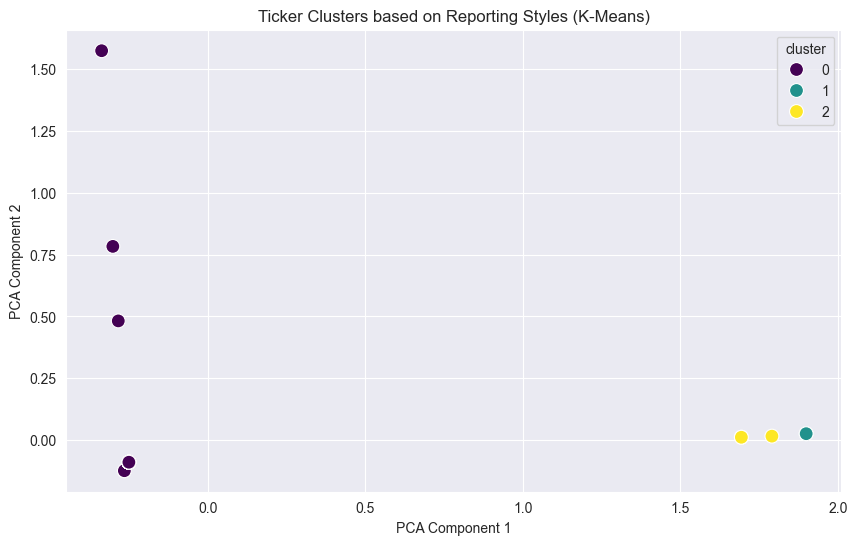

DBSCAN Silhouette Score: 0.72


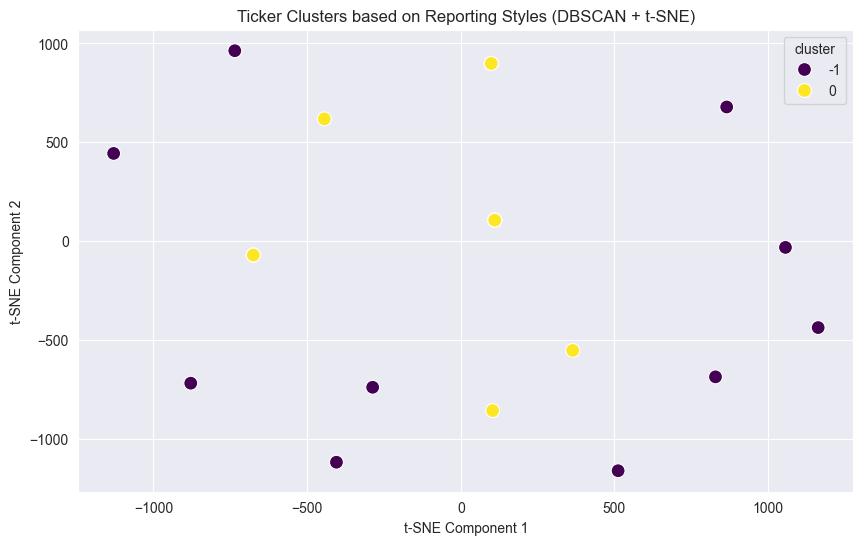

In [368]:
# Define a threshold for missing values (e.g., remove columns with more than 90% missing values)
threshold = 0.7

# Calculate the proportion of missing values for each column
missing_proportion = staged_df_1.isna().mean()

# Filter out columns with high proportion of missing values
filtered_columns = missing_proportion[missing_proportion <= threshold].index

# Create the binary presence/absence matrix using the filtered columns
binary_matrix = staged_df_1.groupby('ticker')[filtered_columns[4:]].apply(lambda df: df.notna().any()).astype(int)

# Try different numbers of clusters
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(binary_matrix)
    silhouette_avg = silhouette_score(binary_matrix, clusters)
    print(f'Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.2f}')

# Choose the best number of clusters based on the silhouette scores above
n_clusters = 3  # Adjust this based on the silhouette scores
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(binary_matrix)

# Add the cluster labels to the binary matrix for visualization
binary_matrix['cluster'] = clusters

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(binary_matrix.drop('cluster', axis=1))

# Create a DataFrame for visualization
visual_df = pd.DataFrame(pca_result, columns=['pca1', 'pca2'])
visual_df['cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visual_df, x='pca1', y='pca2', hue='cluster', palette='viridis', s=100)
plt.title('Ticker Clusters based on Reporting Styles (K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Apply DBSCAN without standardization
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(binary_matrix.drop('cluster', axis=1))

# Calculate silhouette score for DBSCAN if there are more than one cluster
if len(set(dbscan_clusters)) > 1:  # Silhouette score requires more than one cluster
    silhouette_avg = silhouette_score(binary_matrix.drop('cluster', axis=1), dbscan_clusters)
    print(f'DBSCAN Silhouette Score: {silhouette_avg:.2f}')
else:
    print('DBSCAN resulted in a single cluster.')

# Use t-SNE to reduce dimensions for visualization
tsne_result = TSNE(n_components=2, random_state=42).fit_transform(binary_matrix.drop('cluster', axis=1))

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(tsne_result, columns=['tsne1', 'tsne2'])
tsne_df['cluster'] = dbscan_clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='cluster', palette='viridis', s=100)
plt.title('Ticker Clusters based on Reporting Styles (DBSCAN + t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

Number of clusters: 2, Silhouette Score: 0.45
Number of clusters: 3, Silhouette Score: 0.40
Number of clusters: 4, Silhouette Score: 0.35
Number of clusters: 5, Silhouette Score: 0.15
Number of clusters: 6, Silhouette Score: 0.14
Number of clusters: 7, Silhouette Score: 0.15
Number of clusters: 8, Silhouette Score: 0.18
Number of clusters: 9, Silhouette Score: 0.18


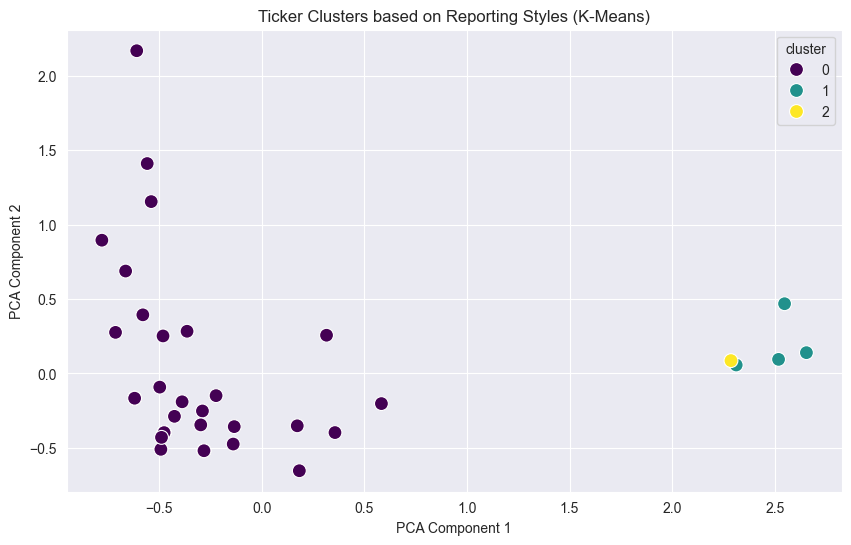

DBSCAN Silhouette Score: -0.09


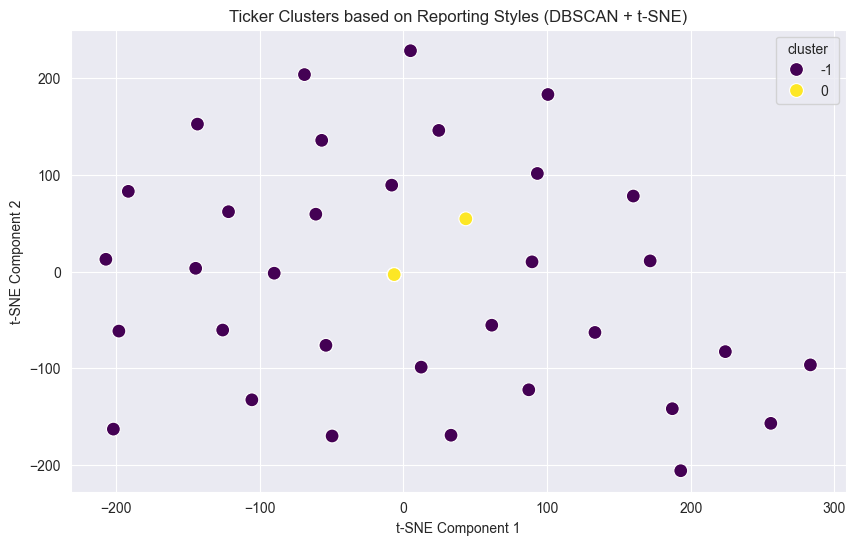

In [367]:
# Define a threshold for missing values (e.g., remove columns with more than 90% missing values)
threshold = 0.7

# Calculate the proportion of missing values for each column
missing_proportion = ten_q_df.isna().mean()

# Filter out columns with high proportion of missing values
filtered_columns = missing_proportion[missing_proportion <= threshold].index

# Create the binary presence/absence matrix using the filtered columns
binary_matrix = ten_q_df.groupby('ticker')[filtered_columns[4:]].apply(lambda df: df.notna().any()).astype(int)

# Try different numbers of clusters
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(binary_matrix)
    silhouette_avg = silhouette_score(binary_matrix, clusters)
    print(f'Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.2f}')

# Choose the best number of clusters based on the silhouette scores above
n_clusters = 3  # Adjust this based on the silhouette scores
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(binary_matrix)

# Add the cluster labels to the binary matrix for visualization
binary_matrix['cluster'] = clusters

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(binary_matrix.drop('cluster', axis=1))

# Create a DataFrame for visualization
visual_df = pd.DataFrame(pca_result, columns=['pca1', 'pca2'])
visual_df['cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visual_df, x='pca1', y='pca2', hue='cluster', palette='viridis', s=100)
plt.title('Ticker Clusters based on Reporting Styles (K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Apply DBSCAN without standardization
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(binary_matrix.drop('cluster', axis=1))

# Calculate silhouette score for DBSCAN if there are more than one cluster
if len(set(dbscan_clusters)) > 1:  # Silhouette score requires more than one cluster
    silhouette_avg = silhouette_score(binary_matrix.drop('cluster', axis=1), dbscan_clusters)
    print(f'DBSCAN Silhouette Score: {silhouette_avg:.2f}')
else:
    print('DBSCAN resulted in a single cluster.')

# Use t-SNE to reduce dimensions for visualization
tsne_result = TSNE(n_components=2, random_state=42).fit_transform(binary_matrix.drop('cluster', axis=1))

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(tsne_result, columns=['tsne1', 'tsne2'])
tsne_df['cluster'] = dbscan_clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='cluster', palette='viridis', s=100)
plt.title('Ticker Clusters based on Reporting Styles (DBSCAN + t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

#### 3rd step: Consolidating accounts with NLP

#### 4th step: Filtering for a certain threshold of maximum % of nan-values per account

In [313]:
# Get the cols per type of report and threshold
df = ten_q_df
threshold = 0.6

mask = (df.isna().sum()/len(df) <= threshold).to_list()
cols= [df.columns.to_list()[ind] for ind, col in enumerate(mask) if col==True]
cols

['end_date',
 'year',
 'ticker',
 'form',
 'AccountsPayableCurrent',
 'AccumulatedOtherComprehensiveIncomeLossNetOfTax',
 'Assets',
 'AssetsCurrent',
 'CashAndCashEquivalentsAtCarryingValue',
 'CommonStockSharesAuthorized',
 'CommonStockSharesIssued',
 'EarningsPerShareBasic',
 'EarningsPerShareDiluted',
 'Goodwill',
 'IncomeTaxExpenseBenefit',
 'LiabilitiesAndStockholdersEquity',
 'LiabilitiesCurrent',
 'OtherAssetsNoncurrent',
 'OtherLiabilitiesNoncurrent',
 'PropertyPlantAndEquipmentNet',
 'RetainedEarningsAccumulatedDeficit',
 'StockholdersEquity',
 'WeightedAverageNumberOfDilutedSharesOutstanding']

#### Analyzing the distribution of the accounts filtered for

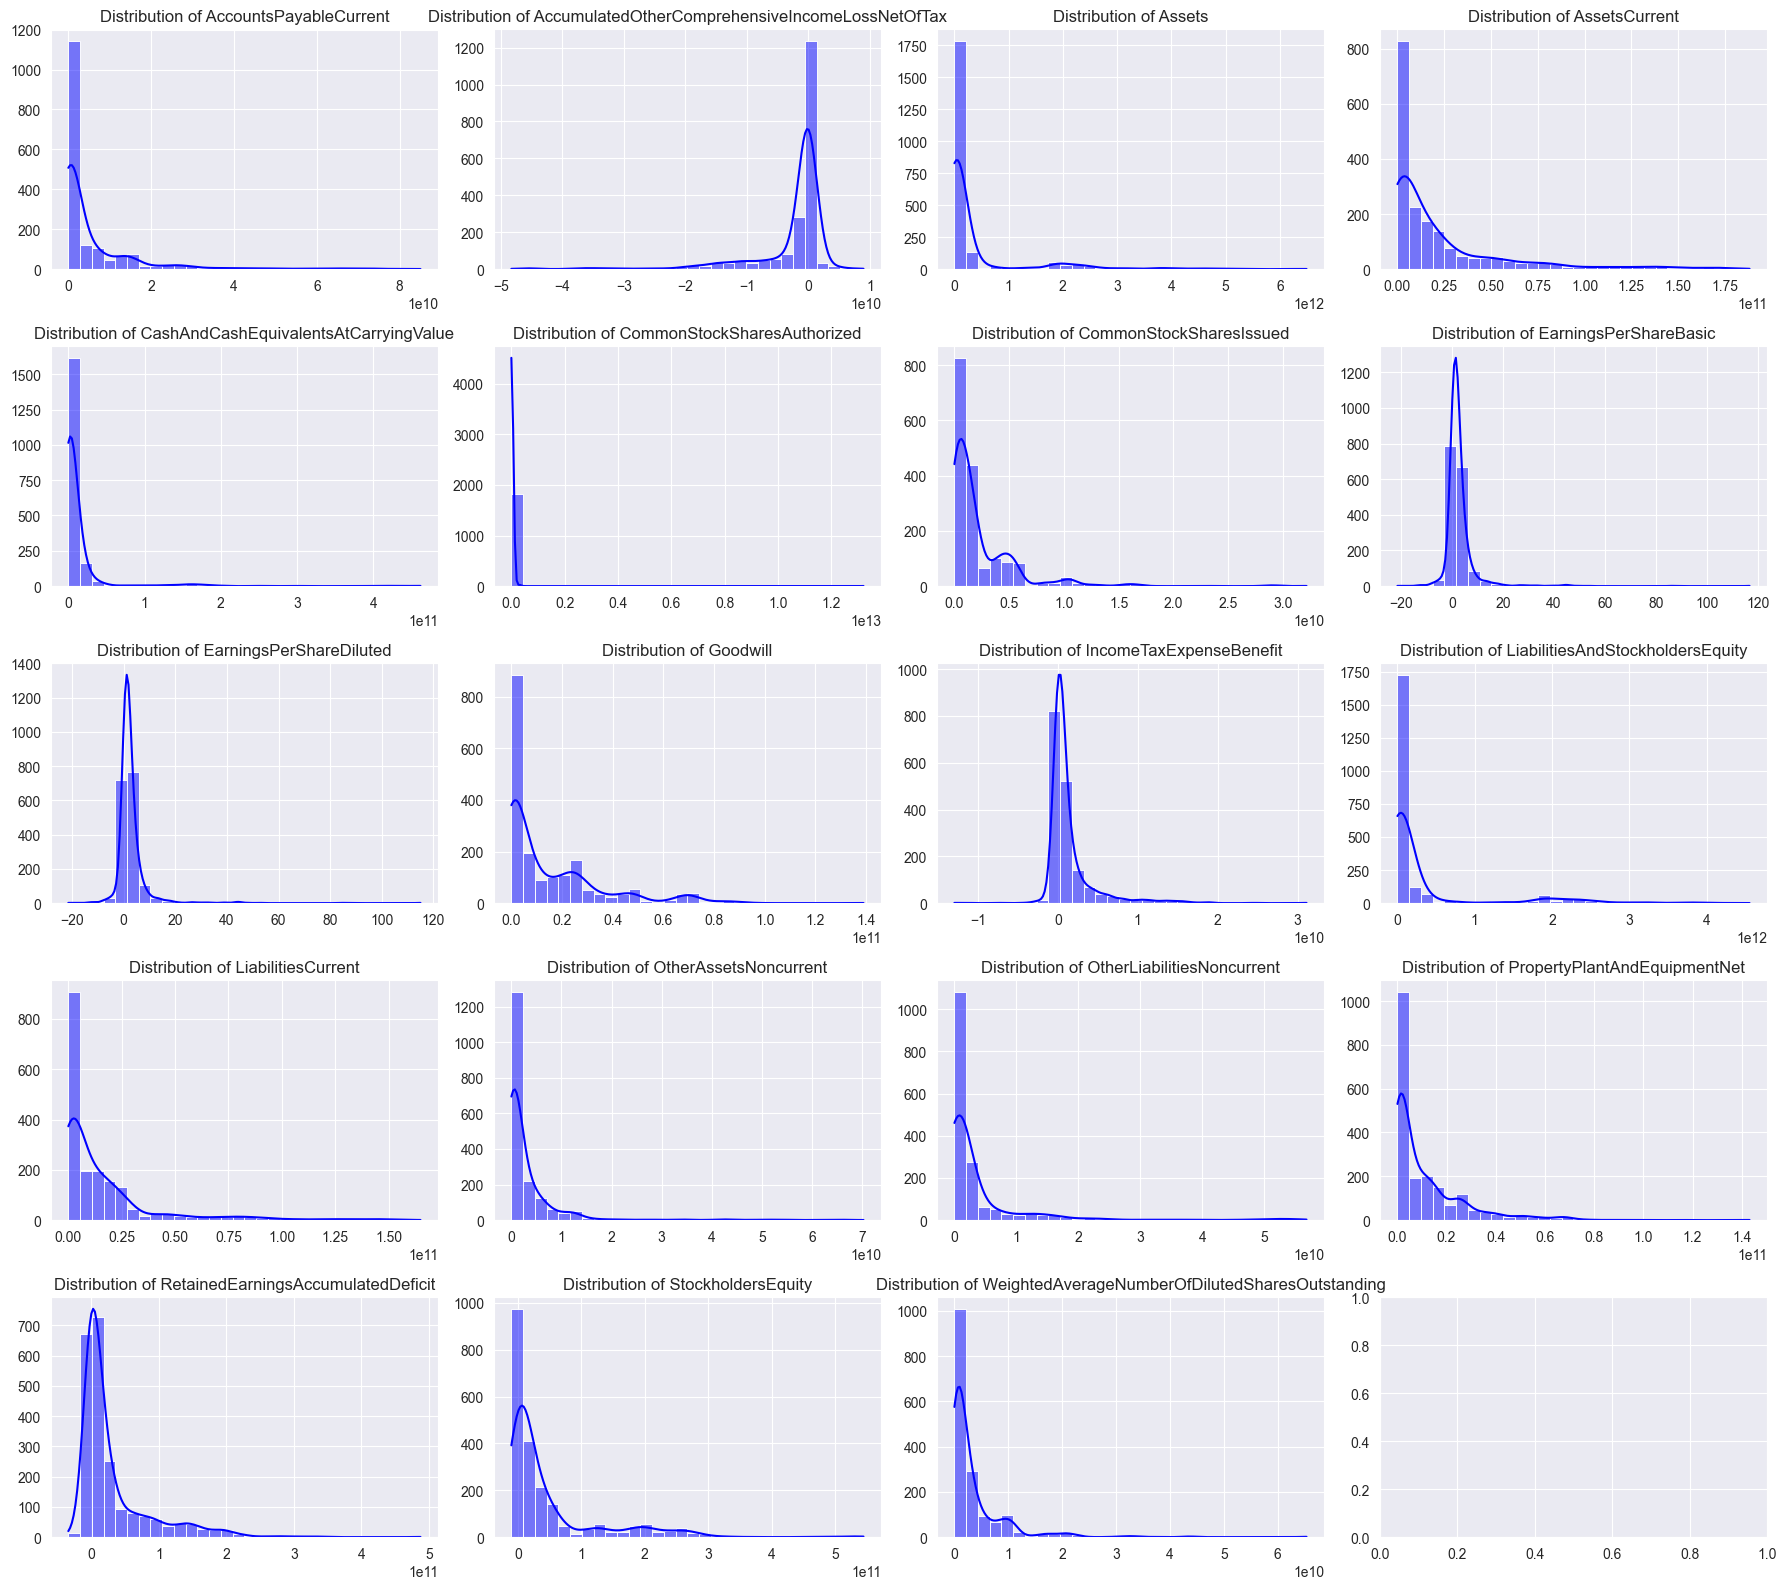

In [317]:
# Set the style
sns.set_style('darkgrid')

# Plot distributions of numerical variables
numerical_cols = cols[4:]

# Plot settings
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(18, 16))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, color='blue', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

**Comments**

In [ ]:
# TO DO

**Disclaimer:**
Propose vs Do now feature engineering in this notebook

### Creating a target column "anomaly"
As a binary classification.
We will have to merge the 2 data sources in order to determine if each report is anomlous or not

In [282]:
merged_df = staged_df_1.merge(anomaly_cases, how="left",left_on=["ticker","year"], right_on=["Anomaly Ticker","Scandal Year"], indicator=True)
merged_df.drop(labels=["Scandal Year","Anomaly Ticker","cik_str"], axis=1, inplace=True)
merged_df['anomaly'] = (merged_df['_merge'] == 'both').astype(int)
merged_df.drop(labels=["_merge"], axis=1, inplace=True)

In [284]:
merged_df.head()

,end_date,year,ticker,form,AcceleratedShareRepurchaseProgramAdjustment,AcceleratedShareRepurchasesFinalPricePaidPerShare,AcceleratedShareRepurchasesSettlementPaymentOrReceipt,AccountsAndNotesReceivableNet,AccountsAndOtherReceivablesNetCurrent,AccountsNotesAndLoansReceivableNetCurrent,...,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfShareOutstandingBasicAndDiluted,WeightedAverageNumberOfSharesContingentlyIssuable,WeightedAverageNumberOfSharesIssuedBasic,WeightedAverageNumberOfSharesOutstandingBasic,WeightedAverageNumberOfSharesRestrictedStock,WithdrawalFromContractHoldersFunds,WorkersCompensationLiabilityCurrent,WriteOffOfDeferredDebtIssuanceCost,anomaly
0,2008-01-01,2008,CAKE,10-K,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2008-01-31,2008,MDLZ,10-K,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2008-02-02,2008,TGT,10-K,NaN,NaN,NaN,NaN,NaN,NaN,...,850800000.0,NaN,NaN,NaN,845400000.0,NaN,NaN,NaN,NaN,1
3,2008-02-02,2008,TGT,10-K/A,NaN,NaN,NaN,NaN,NaN,NaN,...,850800000.0,NaN,NaN,NaN,845400000.0,NaN,NaN,NaN,NaN,1
4,2008-02-02,2008,TGT,10-Q,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


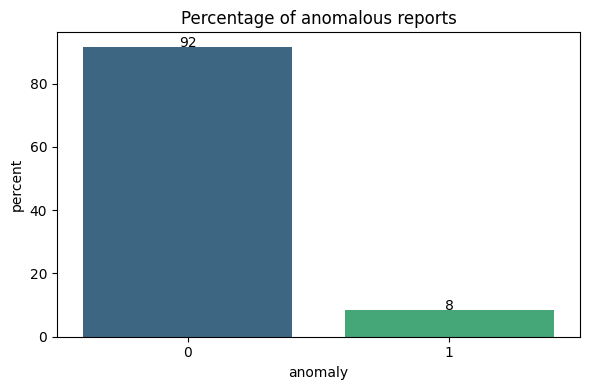

In [305]:
# Plotting the number of reports per type of form
plt.figure(figsize=(6,4))
ax = sns.countplot(x="anomaly", data=merged_df, hue="anomaly", legend=False, stat='percent', palette='viridis')

# Add count values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 3), 
                textcoords = 'offset points')

plt.title("Percentage of anomalous reports")
plt.tight_layout()
plt.show()

### Multivariate Analysis

In [ ]:
# Replicate Pablo's code but with our data
# TO DO

## Saving dataset for Feature Engineering and Modeling

In [324]:
# Save the processed dataframe to a CSV file
output_file_path = '../data/staged/staged_model_data.csv'
merged_df.to_csv(output_file_path, index=False)


print(f"Processed dataframe saved to {output_file_path}")

Processed dataframe saved to data/staged/staged_model_data.csv


In [ ]:
# organize repo before meeting of tomorrow